# Difference in differences

In [2]:
# Install and load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wbgapi as wb
from math import log
from linearmodels import PanelOLS
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import patsy
from linearmodels.panel import PanelOLS as fe

## 2 by 2

In [3]:
data = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/evaluation.dta")

data["enrolled"] = data["enrolled"].astype("category")
data["enrolled"] = data["enrolled"].cat.rename_categories(["Control","Treatment"])


In [4]:
data2= (data
       .groupby(['enrolled', 'round'])
       .agg({'enrolled':'first', 'round':'first',
             'health_expenditures': ['mean', 'std']
            }))


data2.columns = ["_".join(x) for x in data2.columns]

data2=data2.reset_index(drop=True)

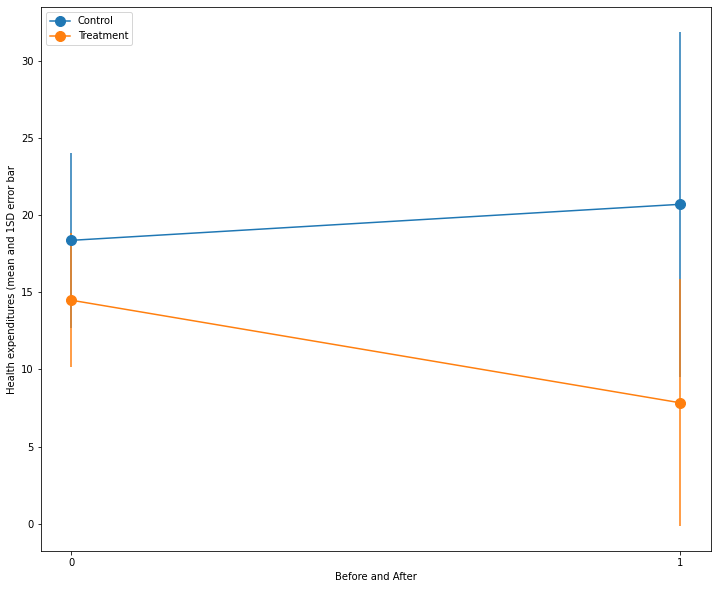

In [5]:
dfp = data2.pivot(index='round_first', columns='enrolled_first', values='health_expenditures_mean')
yerr = data2.pivot(index='round_first', columns='enrolled_first', values='health_expenditures_std')


dfp.plot(
    figsize=(12, 10),
    marker='.', 
    markersize=20, 
    title='',
    xlabel='Before and After',
    ylabel='Health expenditures (mean and 1SD error bar',
    yerr = yerr,
    xticks=data2['round_first'].drop_duplicates().sort_values().astype('int'))

plt.legend(loc="upper left")
plt.show();


## Fixed Effects

In [5]:
data = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/autor-jole-2003.dta")


In [6]:
data2 = data[data['year'] >= 79.0]
data3 = data2[data2['year'] <= 95.0]
data4 = data3[data3['state'] != 98.0]


In [7]:
data4['year'] = pd.to_numeric(data4['year'])
data4["trend"] = data4["year"]-78

data4["state_trend"] = data4["state"]+data4["trend"]
# data4['state_trend'] = [(s,y) for s,y in zip(data4.state, data4.trend)]
data4['annemp'] = pd.to_numeric(data4['annemp'])
data4["state_year"] = [(s,y) for s,y in zip(data4.state, data4.year)]
# data4

In [8]:
admico_list = ["admico_2", "admico_1", "admico0", "admico1", "admico2", "admico3", "mico4"]

In [9]:
data5 = data4[['state', 'year','state_year', 'state_trend','annemp', 'lnths','admico_2', 'admico_1', 'admico0', 'admico1', 'admico2', 'admico3', 'mico4', 'admppa_2', 'admppa_1', 'admppa0', 'admppa1', 'admppa2', 'admppa3', 'mppa4','admgfa_2','admgfa_1', 'admgfa0','admgfa1', 'admgfa2','admgfa3', 'mgfa4', 'trend']]
data5_reset=data5.set_index(['state', 'state_trend'])

formula = '''lnths ~ 
np.log(data5_reset.annemp) + + admico_2 + admico_1 + admico0 + admico1 + admico2 + admico3 + mico4 + admppa_2 + admppa_1 + admppa0 + admppa1 + admppa2 + admppa3 + mppa4 + admgfa_2 + admgfa_1  + admgfa0 + admgfa1 + admgfa2 + admgfa3 + mgfa4 - 1
'''
y, x_data = patsy.dmatrices(formula, data5_reset, return_type = 'dataframe')

fixed = fe(y, exog = x_data, entity_effects = True, time_effects = True, drop_absorbed=True).fit(cov_type = 'clustered', cluster_entity = True)
# fixed.summary().tables[1]

In [10]:
df_a = np.float_(pd.DataFrame(fixed.summary.tables[1].data).iloc[2:9, [1, 5, 6]]) * 100 + 7.9
df_a
df = pd.DataFrame(df_a, columns=['point', 'l', 'u'])
df['admico'] = admico_list
df['xpos'] = range(len(admico_list))
df1 = pd.melt(df, id_vars=['point', 'admico', 'xpos'], value_vars=['l', 'u'])

C:\Users\Jhon\AppData\Local\Temp\ipykernel_4256\4227953583.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_lbls)


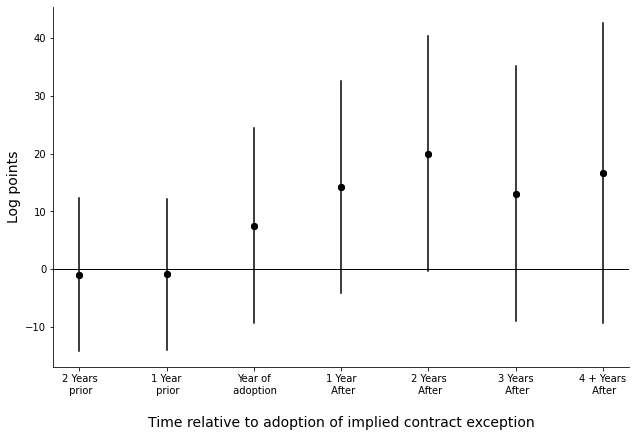

In [11]:
fig = plt.figure(figsize=(8, 5), facecolor = 'white')
ax = fig.add_axes([.1, 1, 1, 1])
plt.scatter('xpos', 'point', data = df1, c = 'black')
for i in admico_list:
    ref_data = df1[df1.admico ==i]
    plt.plot('xpos', 'value', data = ref_data, c = 'black')
ax.spines[['top', 'right']].set_visible(False)

plt.xlabel("\nTime relative to adoption of implied contract exception", size = 14)
plt.ylabel("Log points", size = 14)
plt.axhline(0, lw = 1, c = "black")

x_lbls = [
    '2 Years\n prior', '1 Year\n prior', 'Year of\n adoption', 
    '1 Year\n After', '2 Years\n After', '3 Years\n After',
    '4 + Years\n After'
]
          

ax.set_xticklabels(x_lbls)
ax.set_xticks(range(len(x_lbls)))
plt.show();